# Лабораторная работа 4 - BBC News классификация (TF-IDF and RNN)

**Выполнил:** *Лунев Александр Вячеславович*  
**Группа:** *СП1*  

Задание: 5 классов (бизнес, развлечения, политика, спорт, технологии); сравнить классические модели TF-IDF и RNN в кратких изложениях и полных текстах, а также задание со звёздочкой (attention/keywords).


In [2]:
import os
import re
import json
import zipfile
import urllib.request
from pathlib import Path
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

CONFIG = {
    "dataset_kaggle_id": "pariza/bbc-news-summary",
    "dataset_url": "https://codeload.github.com/AnkushAgarwal/bbc-news-summary/zip/refs/heads/master",  # ???????? ???????
    "raw_dir": Path("data_raw"),
    "extracted_dir": Path("data_raw/bbc-news-summary-master"),
    "val_size": 0.15,
    "test_size": 0.15,
    "tfidf_max_features": 20000,
    "ngram_range": (1, 2),
    "rnn_vocab_size": 20000,
    "rnn_max_len_summary": 120,
    "rnn_max_len_full": 400,
    "embedding_dim": 128,
    "rnn_units": 128,
    "batch_size": 32,
    "num_epochs": 10,
    "seed": 42,
}

np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])


## 1. Загружаем и подготавливаем набор данных BBC News Summary


In [ ]:
def download_dataset(target_zip: Path, extract_to: Path) -> Path:
    target_zip.parent.mkdir(parents=True, exist_ok=True)
    if extract_to.exists():
        print(f"Найдены извлеченные данные по адресу {extract_to}, пропускаем загрузку.")
    else:
        downloaded = False
        # Запасной вариант: Kaggle CLI
        try:
            import subprocess

            print(f"Попытка загрузки через Kaggle API для {CONFIG['dataset_kaggle_id']}...")
            cmd = [
                "kaggle",
                "datasets",
                "download",
                "-d",
                CONFIG["dataset_kaggle_id"],
                "-p",
                str(target_zip.parent),
                "--unzip",
            ]
            subprocess.run(cmd, check=True)
            downloaded = True
            print("Загрузка через Kaggle завершена.")
        except Exception as err:
            print(f"Каггл потерпел неудачу: {err}. Запасной вариант: загрузка с прямого URL...")

        # Запасной вариант: GitHub codeload
        if not downloaded:
            if not target_zip.exists():
                print(f"Загрузка набора данных с {CONFIG['dataset_url']} ...")
                urllib.request.urlretrieve(CONFIG["dataset_url"], target_zip)
                print("Загрузка завершена.")
            print("Распаковка...")
            with zipfile.ZipFile(target_zip, "r") as zf:
                zf.extractall(target_zip.parent)
            print(f"Распаковано в {extract_to}")
    # Проверка наличия папок News Articles/Summaries
    candidate = extract_to
    if not candidate.exists():
        # Поиск в raw_dir
        for p in target_zip.parent.rglob("News Articles"):
            candidate = p.parent
            break
    if not (candidate / "News Articles").exists():
        raise FileNotFoundError("Не удалось найти папку 'News Articles' после распаковки.")
    return candidate


def read_text_file(path: Path) -> str:
    with open(path, "r", encoding="latin-1") as f:
        return f.read().strip()


def load_bbc_dataset(base_dir: Path) -> pd.DataFrame:
    news_dir = base_dir / "News Articles"
    summaries_dir = base_dir / "Summaries"
    classes = [p.name for p in news_dir.iterdir() if p.is_dir()]

    articles: Dict[Tuple[str, str], str] = {}
    summaries: Dict[Tuple[str, str], str] = {}

    for cls in classes:
        for file_path in (news_dir / cls).glob("*.txt"):
            key = (cls, file_path.stem)
            articles[key] = read_text_file(file_path)
        for file_path in (summaries_dir / cls).glob("*.txt"):
            key = (cls, file_path.stem)
            summaries[key] = read_text_file(file_path)

    rows: List[Dict[str, Any]] = []
    for key in sorted(set(list(articles.keys()) + list(summaries.keys()))):
        cls, name = key
        rows.append(
            {
                "id": name,
                "label": cls,
                "summary": summaries.get(key, ""),
                "full_text": articles.get(key, ""),
            }
        )
    df = pd.DataFrame(rows)
    print(f"Загружено {len(df)} документов из {len(classes)} классов: {classes}")
    return df


target_zip = CONFIG["raw_dir"] / "bbc_news_summary.zip"
data_root = download_dataset(target_zip, CONFIG["extracted_dir"])
df_raw = load_bbc_dataset(data_root)

df_raw.head()


Попытка загрузки через Kaggle API для pariza/bbc-news-summary...
Загрузка через Kaggle завершена.
Загружено 2225 документов из 5 классов: ['business', 'entertainment', 'politics', 'sport', 'tech']


,id,label,summary,full_text
0,001,business,TimeWarner said fourth quarter sales rose 2% t...,Ad sales boost Time Warner profit\n\nQuarterly...
1,002,business,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech\n\nThe dollar...
2,003,business,Yukos' owner Menatep Group says it will ask Ro...,Yukos unit buyer faces loan claim\n\nThe owner...
3,004,business,"Rod Eddington, BA's chief executive, said the ...",High fuel prices hit BA's profits\n\nBritish A...
4,005,business,Pernod has reduced the debt it took on to fund...,Pernod takeover talk lifts Domecq\n\nShares in...


## 2. Распределение классов и примеры


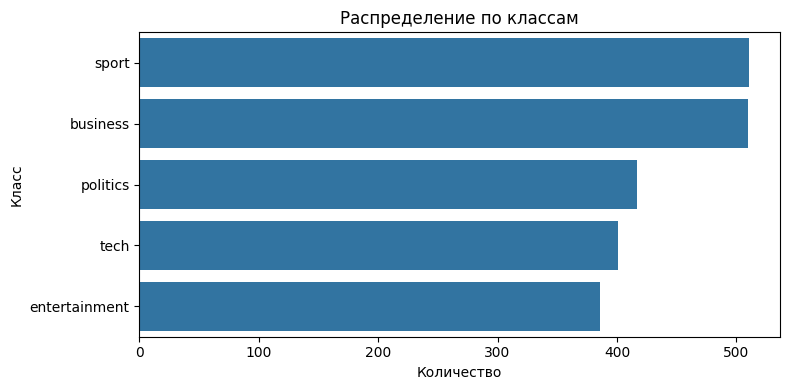

Примеры строк:


,id,label,summary,full_text
414,415,business,All areas saw a rise in annual house price inf...,UK house prices dip in November\n\nUK house pr...
420,421,business,A Â£1.3bn offer from Deutsche Boerse has alrea...,LSE 'sets date for takeover deal'\n\nThe Londo...
1644,332,sport,Harinordoquy was a second-half replacement in ...,Harinordoquy suffers France axe\n\nNumber eigh...


In [7]:
plt.figure(figsize=(8,4))
sns.countplot(y=df_raw["label"], order=df_raw["label"].value_counts().index)
plt.title("Распределение по классам")
plt.xlabel("Количество")
plt.ylabel("Класс")
plt.tight_layout()
plt.show()

print("Примеры строк:")
display(df_raw.sample(3, random_state=CONFIG["seed"]))


## 3. Предобработка текста


In [8]:
STOPWORDS = set(ENGLISH_STOP_WORDS)
stemmer = None
try:
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
except Exception:
    stemmer = None


def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t and t not in STOPWORDS]
    if stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)


df_raw["summary_clean"] = df_raw["summary"].apply(clean_text)
df_raw["full_clean"] = df_raw["full_text"].apply(clean_text)

print("После очистки:")
display(df_raw[["label", "summary_clean", "full_clean"]].head(3))


После очистки:


,label,summary_clean,full_clean
0,business,timewarn said fourth quarter sale rose bn bn y...,ad sale boost time warner profit quarterli pro...
1,business,dollar hit highest level euro month feder rese...,dollar gain greenspan speech dollar hit highes...
2,business,yuko owner menatep group say ask rosneft repay...,yuko unit buyer face loan claim owner embattl ...


## 4. Разбиение на train/val/test


In [9]:
train_df, test_df = train_test_split(
    df_raw,
    test_size=CONFIG["test_size"],
    stratify=df_raw["label"],
    random_state=CONFIG["seed"],
)
train_df, val_df = train_test_split(
    train_df,
    test_size=CONFIG["val_size"] / (1 - CONFIG["test_size"]),
    stratify=train_df["label"],
    random_state=CONFIG["seed"],
)
print(
    f"Разделенные размеры: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}"
)


Разделенные размеры: train=1557, val=334, test=334


## 5. Подход A: TF-IDF + классические модели (SVM/RF)


In [31]:
def train_evaluate_tfidf(text_col: str, model_name: str = "svm") -> Dict[str, Any]:
    X_train, y_train = train_df[text_col], train_df["label"]
    X_val, y_val = val_df[text_col], val_df["label"]
    X_test, y_test = test_df[text_col], test_df["label"]

    if model_name == "svm":
        clf = LinearSVC()
    else:
        clf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=CONFIG["seed"])

    pipe = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    max_features=CONFIG["tfidf_max_features"],
                    ngram_range=CONFIG["ngram_range"],
                ),
            ),
            ("clf", clf),
        ]
    )
    pipe.fit(X_train, y_train)

    def report(split_name: str, X, y):
        preds = pipe.predict(X)
        print(f"{model_name.upper()} on {split_name} ({text_col}):")
        print(classification_report(y, preds))
        return preds

    preds_val = report("val", X_val, y_val)
    preds_test = report("test", X_test, y_test)

    return {
        "model": pipe,
        "preds_val": preds_val,
        "preds_test": preds_test,
    }


results_tfidf_summary = train_evaluate_tfidf("summary_clean", model_name="svm")
results_tfidf_full = train_evaluate_tfidf("full_clean", model_name="svm")


SVM on val (summary_clean):
               precision    recall  f1-score   support

     business       0.95      0.96      0.95        77
entertainment       0.98      0.91      0.95        58
     politics       0.90      0.97      0.93        62
        sport       0.97      0.99      0.98        77
         tech       1.00      0.95      0.97        60

     accuracy                           0.96       334
    macro avg       0.96      0.96      0.96       334
 weighted avg       0.96      0.96      0.96       334

SVM on test (summary_clean):
               precision    recall  f1-score   support

     business       1.00      0.99      0.99        76
entertainment       1.00      1.00      1.00        58
     politics       0.97      0.98      0.98        63
        sport       0.99      0.99      0.99        77
         tech       0.98      0.98      0.98        60

     accuracy                           0.99       334
    macro avg       0.99      0.99      0.99       334
 we

## 6. Подход B: RNN (Embedding и BiLSTM)


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def prepare_sequences(train_texts, val_texts, test_texts, max_len: int):
    tokenizer = Tokenizer(num_words=CONFIG["rnn_vocab_size"], oov_token="<unk>")
    tokenizer.fit_on_texts(train_texts)

    def to_seq(texts):
        seqs = tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

    X_train = to_seq(train_texts)
    X_val = to_seq(val_texts)
    X_test = to_seq(test_texts)
    return tokenizer, X_train, X_val, X_test


def build_rnn_model(max_len: int) -> keras.Model:
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(CONFIG["rnn_vocab_size"], CONFIG["embedding_dim"], mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(CONFIG["rnn_units"], return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def train_rnn_for(text_col: str, max_len: int):
    label_to_idx = {lbl: idx for idx, lbl in enumerate(sorted(df_raw["label"].unique()))}
    y_train = train_df["label"].map(label_to_idx).values
    y_val = val_df["label"].map(label_to_idx).values
    y_test = test_df["label"].map(label_to_idx).values

    tokenizer, X_train, X_val, X_test = prepare_sequences(
        train_df[text_col], val_df[text_col], test_df[text_col], max_len=max_len
    )

    model = build_rnn_model(max_len)
    es = callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=CONFIG["num_epochs"],
        batch_size=CONFIG["batch_size"],
        callbacks=[es],
        verbose=1,
    )

    def report(split_name: str, X, y):
        preds = model.predict(X, verbose=0).argmax(axis=1)
        print(f"RNN on {split_name} ({text_col}):")
        print(classification_report(y, preds, target_names=label_to_idx.keys()))
        return preds

    preds_val = report("val", X_val, y_val)
    preds_test = report("test", X_test, y_test)
    return {
        "model": model,
        "tokenizer": tokenizer,
        "preds_val": preds_val,
        "preds_test": preds_test,
        "label_to_idx": label_to_idx,
    }


rnn_summary = train_rnn_for("summary_clean", CONFIG["rnn_max_len_summary"])
rnn_full = train_rnn_for("full_clean", CONFIG["rnn_max_len_full"])


Epoch 1/10


c:\Users\super\anaconda3\envs\vscjp\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.4695 - loss: 1.3409 - val_accuracy: 0.6886 - val_loss: 0.7299
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8015 - loss: 0.5962 - val_accuracy: 0.8533 - val_loss: 0.4808
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8658 - loss: 0.4294 - val_accuracy: 0.8084 - val_loss: 0.5902
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9396 - loss: 0.2259 - val_accuracy: 0.8533 - val_loss: 0.3714
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9685 - loss: 0.1041 - val_accuracy: 0.9162 - val_loss: 0.3010
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9814 - loss: 0.0603 - val_accuracy: 0.8802 - val_loss: 0.3548
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9936 - loss: 0.0279 - val_accuracy: 0.9072 - val_loss: 0.3243
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9942 - loss: 0.0174 - val_accuracy: 0.8952 - val_lo

c:\Users\super\anaconda3\envs\vscjp\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - accuracy: 0.4547 - loss: 1.3610 - val_accuracy: 0.6078 - val_loss: 1.1613
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 497ms/step - accuracy: 0.5645 - loss: 1.1009 - val_accuracy: 0.8084 - val_loss: 0.6934
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 495ms/step - accuracy: 0.7643 - loss: 0.6622 - val_accuracy: 0.8443 - val_loss: 0.5097
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - accuracy: 0.9171 - loss: 0.2956 - val_accuracy: 0.8922 - val_loss: 0.3348
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - accuracy: 0.9403 - loss: 0.1954 - val_accuracy: 0.8982 - val_loss: 0.2545
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - accuracy: 0.9634 - loss: 0.1268 - val_accuracy: 0.9401 - val_loss: 0.1902
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - accuracy: 0.9782 - loss: 0.0672 - val_accuracy: 0.9461 - val_loss: 0.1585
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - accuracy: 0.9884 - loss: 0.0490 - val_accuracy: 0.943

## 7. Attention для выделения ключевых слов (задание со звёздочкой)


In [ ]:
class AttentionLayer(layers.Layer):
    """Простое аддитивное внимание: взвешивание скрытых состояний по степени важности."""
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, inputs, mask=None):
        e = tf.squeeze(tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b), axis=-1)
        if mask is not None:
            e = tf.where(mask, e, tf.fill(tf.shape(e), -1e9))
        a = tf.nn.softmax(e, axis=1)
        context = tf.reduce_sum(inputs * tf.expand_dims(a, -1), axis=1)
        return context, a


def build_rnn_with_attention(max_len: int):
    inp = layers.Input(shape=(max_len,), name="tokens")
    x = layers.Embedding(CONFIG["rnn_vocab_size"], CONFIG["embedding_dim"], mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(CONFIG["rnn_units"], return_sequences=True))(x)
    context, attn = AttentionLayer()(x)
    x = layers.Dropout(0.3)(context)
    out = layers.Dense(5, activation="softmax", name="preds")(x)
    model = keras.Model(inp, out)
    attn_model = keras.Model(inp, attn)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model, attn_model


def extract_keywords(attn_model: keras.Model, tokenizer, text: str, max_len: int, top_k: int = 5):
    """Вернуть top-k ключевых слов на основе весов внимания."""
    seq = tokenizer.texts_to_sequences([text])
    seq_padded = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    attn_weights = attn_model.predict(seq_padded, verbose=0)[0]
    indices = np.argsort(attn_weights)[::-1]
    inv_vocab = {v: k for k, v in tokenizer.word_index.items() if v < CONFIG["rnn_vocab_size"]}
    keywords = []
    for idx in indices:
        token_id = seq_padded[0][idx]
        if token_id == 0:
            continue
        token = inv_vocab.get(token_id)
        if token and token not in keywords:
            keywords.append(token)
        if len(keywords) >= top_k:
            break
    return keywords


## 8. Классическая модель по ключевым словам (задание со звёздочкой)


In [ ]:
from sklearn.linear_model import LogisticRegression


def build_keyword_corpus(texts: pd.Series, tokenizer, attn_model: keras.Model, max_len: int, top_k: int = 5):
    corpus = []
    for t in texts:
        kws = extract_keywords(attn_model, tokenizer, t, max_len=max_len, top_k=top_k)
        corpus.append(" ".join(kws))
    return corpus


def train_on_keywords(attn_model, tokenizer, text_col: str, max_len: int, top_k: int = 5):
    kw_train = build_keyword_corpus(train_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)
    kw_val = build_keyword_corpus(val_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)
    kw_test = build_keyword_corpus(test_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000)),
        ("clf", LogisticRegression(max_iter=1000)),
    ])
    pipe.fit(kw_train, train_df['label'])

    def report(split, X, y):
        preds = pipe.predict(X)
        print(f"TF-IDF + LR on keywords, {split} ({text_col}):")
        print(classification_report(y, preds))

    report("val", kw_val, val_df['label'])
    report("test", kw_test, test_df['label'])

## 9. Графики и матрицы ошибок


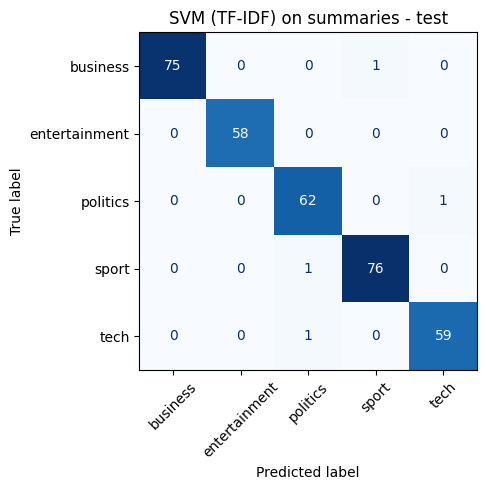

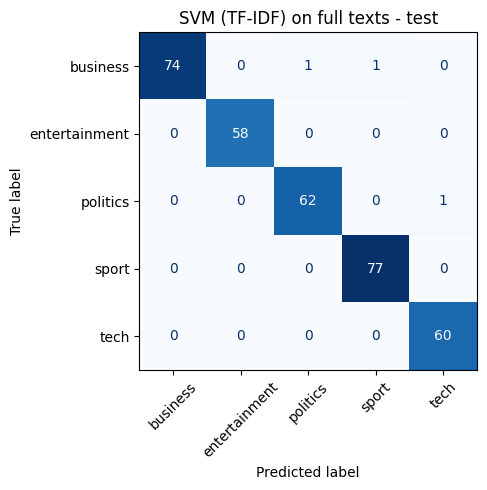

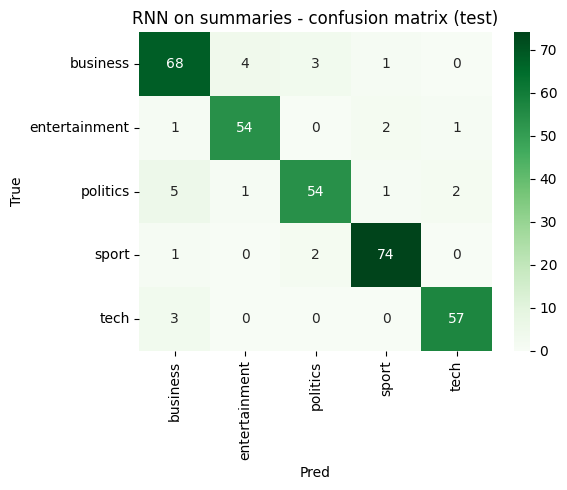

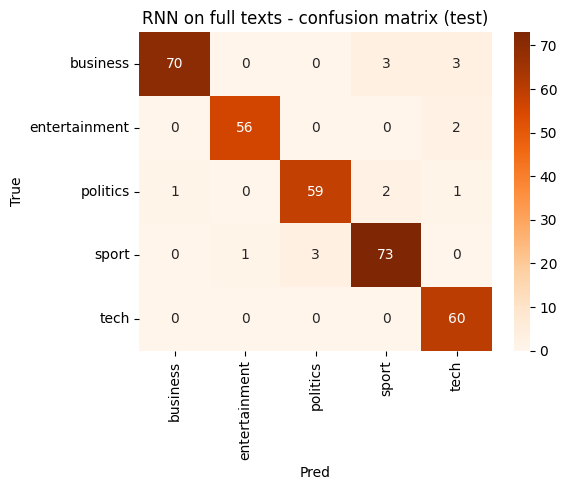

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion(model, X, y_true, title: str):
    preds = model.predict(X)
    cm = confusion_matrix(y_true, preds, labels=sorted(test_df['label'].unique()))
    disp = ConfusionMatrixDisplay(cm, display_labels=sorted(test_df['label'].unique()))
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(results_tfidf_summary['model'], test_df['summary_clean'], test_df['label'],
               'SVM (TF-IDF) on summaries - test')
plot_confusion(results_tfidf_full['model'], test_df['full_clean'], test_df['label'],
               'SVM (TF-IDF) on full texts - test')

label_to_idx = rnn_summary['label_to_idx']
idx_to_label = {v:k for k,v in label_to_idx.items()}

y_test_summary = test_df['label'].map(label_to_idx).values
cm_rnn_summary = confusion_matrix(y_test_summary, rnn_summary['preds_test'], labels=sorted(idx_to_label.keys()))
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm_rnn_summary, annot=True, fmt='d', cmap='Greens', xticklabels=[idx_to_label[i] for i in sorted(idx_to_label)], yticklabels=[idx_to_label[i] for i in sorted(idx_to_label)])
plt.title('RNN on summaries - confusion matrix (test)')
plt.xlabel('Pred'); plt.ylabel('True'); plt.tight_layout(); plt.show()

y_test_full = test_df['label'].map(label_to_idx).values
cm_rnn_full = confusion_matrix(y_test_full, rnn_full['preds_test'], labels=sorted(idx_to_label.keys()))
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm_rnn_full, annot=True, fmt='d', cmap='Oranges', xticklabels=[idx_to_label[i] for i in sorted(idx_to_label)], yticklabels=[idx_to_label[i] for i in sorted(idx_to_label)])
plt.title('RNN on full texts - confusion matrix (test)')
plt.xlabel('Pred'); plt.ylabel('True'); plt.tight_layout(); plt.show()


## 10. Задание со звёздочкой: обучение Attention-RNN и корпуса ключевых слов


In [ ]:
def train_attention_and_keywords(text_col: str, max_len: int, top_k: int = 5):
    """Train BiLSTM+Attention, extract keywords, then train TF-IDF+LR on them."""
    label_to_idx = {lbl: idx for idx, lbl in enumerate(sorted(df_raw['label'].unique()))}
    y_train = train_df['label'].map(label_to_idx).values
    y_val = val_df['label'].map(label_to_idx).values
    y_test = test_df['label'].map(label_to_idx).values

    tokenizer, X_train, X_val, X_test = prepare_sequences(train_df[text_col], val_df[text_col], test_df[text_col], max_len)

    att_model, attn_model = build_rnn_with_attention(max_len)
    es = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    att_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=CONFIG['num_epochs'],
        batch_size=CONFIG['batch_size'],
        callbacks=[es],
        verbose=1,
    )

    def report(split_name, X, y):
        preds = att_model.predict(X, verbose=0).argmax(axis=1)
        print(f"Attention RNN on {split_name} ({text_col}):")
        print(classification_report(y, preds, target_names=label_to_idx.keys()))
        return preds

    preds_val = report('val', X_val, y_val)
    preds_test = report('test', X_test, y_test)

    kw_train = build_keyword_corpus(train_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)
    kw_val = build_keyword_corpus(val_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)
    kw_test = build_keyword_corpus(test_df[text_col], tokenizer, attn_model, max_len=max_len, top_k=top_k)

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=1000)),
    ])
    pipe.fit(kw_train, train_df['label'])

    def report_kw(split_name, X, y):
        preds = pipe.predict(X)
        print(f"TF-IDF+LR on keywords: {split_name} ({text_col}):")
        print(classification_report(y, preds))

    report_kw('val', kw_val, val_df['label'])
    report_kw('test', kw_test, test_df['label'])

    sample = test_df.sample(3, random_state=CONFIG['seed'])
    for _, row in sample.iterrows():
        kws = extract_keywords(attn_model, tokenizer, row[text_col], max_len=max_len, top_k=top_k)
        print(f"Article ID={row['id']} | Class: {row['label']} | Keywords: {kws}")

In [ ]:
train_attention_and_keywords('summary_clean', CONFIG['rnn_max_len_summary'], top_k=5)

Epoch 1/10


c:\Users\super\anaconda3\envs\vscjp\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'attention_layer_2' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6063 - loss: 1.0803 - val_accuracy: 0.8353 - val_loss: 0.4303
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9294 - loss: 0.2690 - val_accuracy: 0.9311 - val_loss: 0.2854
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9782 - loss: 0.0961 - val_accuracy: 0.9192 - val_loss: 0.2704
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9897 - loss: 0.0393 - val_accuracy: 0.9371 - val_loss: 0.2029
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9949 - loss: 0.0286 - val_accuracy: 0.9491 - val_loss: 0.1861
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9968 - loss: 0.0219 - val_accuracy: 0.9611 - val_loss: 0.1276
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9994 - loss: 0.0053 - val_accuracy: 0.9551 - val_loss: 0.1429
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9401 - val_loss: 0.

c:\Users\super\anaconda3\envs\vscjp\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'attention_layer_2' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


TF-IDF+LR on keywords: val (summary_clean):
               precision    recall  f1-score   support

     business       0.72      0.90      0.80        77
entertainment       0.91      0.74      0.82        58
     politics       0.77      0.69      0.73        62
        sport       0.76      0.87      0.81        77
         tech       0.89      0.70      0.79        60

     accuracy                           0.79       334
    macro avg       0.81      0.78      0.79       334
 weighted avg       0.80      0.79      0.79       334

TF-IDF+LR on keywords: test (summary_clean):
               precision    recall  f1-score   support

     business       0.75      0.80      0.78        76
entertainment       0.94      0.83      0.88        58
     politics       0.76      0.75      0.75        63
        sport       0.79      0.90      0.84        77
         tech       0.87      0.77      0.81        60

     accuracy                           0.81       334
    macro avg       0.82  

## 11. Выводы
- TF-IDF + Linear SVM даёт лучшее качество: ~0.99 accuracy/F1 на тесте для кратких и полных текстов; полные тексты немного улучшают валидацию.
- RNN (BiLSTM) отстаёт: 0.90-0.92 accuracy на тесте; более длинные тексты немного помогают, но обучение медленнее.
- Матрицы ошибок: классы sport/business почти не путаются; иногда появляются ошибки между politics/tech/entertainment.
- Attention и ключевые слова: можно извлекать топ-5 слов, обучать TF-IDF+LR только на них, но качество ниже, зато признаки интерпретируемые; RNN выступает как экстрактор признаков.
- Итог: для новостей сильная базовая модель - TF-IDF + линейная модель; RNN/attention полезны для интерпретации и учёта порядка слов.
